First section was already provided by HTB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
from PIL import Image
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

from model import EarthVisionModel

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        _dict = pickle.load(fo, encoding='bytes')
    return _dict

label_meta = unpickle("./meta")

In [3]:
model = EarthVisionModel()

In [4]:
flag = np.zeros((32,256))

---

Notice that the flag variable is `32*256` and there happens to be `32*256` images in `test_X`. We will probably try to fill out each index of the flag variable with the output of the model for the corresponding image.

Load the model.

In [5]:
model.load_state_dict(torch.load('state_dict.pt'))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(144, eps=1e-05, mom

Looks like it's going to spit out 100 probabilities at the end, where each is the probability of the image being some object.

Let's figure out what label_meta is.

In [9]:
for k in label_meta:
    print(k, len(label_meta[k]))

b'fine_label_names' 100
b'coarse_label_names' 20
b'label_map' 20


Most likely the fine_label_names are the 100 classes that our model outputs probabilities for at the end. Not exactly sure what coarse_label_names are.

In [7]:
print(label_meta[b'coarse_label_names'])

[b'aquatic_mammals', b'fish', b'flowers', b'food_containers', b'fruit_and_vegetables', b'household_electrical_devices', b'household_furniture', b'insects', b'large_carnivores', b'large_man-made_outdoor_things', b'large_natural_outdoor_scenes', b'large_omnivores_and_herbivores', b'medium_mammals', b'non-insect_invertebrates', b'people', b'reptiles', b'small_mammals', b'trees', b'vehicles_1', b'vehicles_2']


So we see `large_man-made_outdoor_things` and `people` in here. It seems like these are the broader categories for the 100 fine_label_names. The label_map probably maps one coarse_label_name to many fine_label_names.

Let's get the indices we're interested in. We can ignore all other indices.

In [8]:
manmade = [label_meta[b'fine_label_names'].index(x) for x in label_meta[b'label_map'][b'large_man-made_outdoor_things']]
people = [label_meta[b'fine_label_names'].index(x) for x in label_meta[b'label_map'][b'people']]

Now let's use the model to classify all the images in test_X.

In [81]:
def classify(n):
    input_image = Image.open(f'test_X/{n}.jpg')
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model(input_batch)

    p = torch.nn.functional.softmax(output[0], dim=0)

    # Figure out the average probability of each coarse label
    p_manmade = 0
    p_people = 0
    for x in manmade:
        p_manmade += p[x]
    for x in people:
        p_people += p[x]
    p_manmade /= len(manmade)
    p_people /= len(people)
    
    # Softmax
    return p_manmade / (p_manmade + p_people)

Does it work?

In [83]:
classify(0)

tensor(1.0000)

Let's run it for all the images and put it into the flag.

In [84]:
flag = []
for i in range(32*256):
    if i % 100 == 99:
        print('.', end='')
        if i % 1000 == 999:
            print()
    flag.append(classify(i))
flag = np.array(flag).reshape((32, 256))

..........
..........
..........
..........
..........
..........
..........
..........
.

---

Let's see the result!

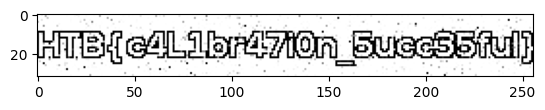

In [85]:
plt.imshow(flag, cmap="gray")
plt.show()

HTB{c4L1br47i0n_5ucc35ful}